In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import t
from scipy.stats import stats


In [2]:
df=pd.read_csv('C:/Users/ketak/Desktop/Springboard/capstone ideas/NYSDOH_clean2.csv')

In [3]:
df.shape

(236147, 36)

In [4]:
df=df.drop('Unnamed: 0',axis=1)

In [5]:
#APR codes:. A higher relative weight is associated with longer length of stay, greater severity of illness, and higher reimbursement. The time of when APR-DRG’s are assigned is unclear. For this reason APR codes will be dropped. More on this in the EDA report
# drop APR codes as APR codes are likely not designaed at the time of admission, and are designated for puporses of reimbursement
df=df.drop(df.iloc[:, 18:26], axis = 1)


In [6]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County',
       'Operating_Certificate_Number', 'Permanent_Facility_Id',
       'Facility_Name', 'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race',
       'Ethnicity', 'Length_of_Stay', 'Type_of_Admission',
       'Patient_Disposition', 'Discharge_Year', 'CCS_Diagnosis_Code',
       'CCS_Diagnosis_Description', 'CCS_Procedure_Code',
       'CCS_Procedure_Description', 'Payment_Typology_1', 'Payment_Typology_2',
       'Payment_Typology_3', 'Birth_Weight', 'Abortion_Edit_Indicator',
       'Emergency_Department_Indicator', 'Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges'],
      dtype='object')

In [7]:
df.Discharge_Year.unique()

array([2014], dtype=int64)

In [8]:
# drop discahrge_year as it is the same across all rows 2014
df=df.drop('Discharge_Year',axis=1)

In [9]:
df.Abortion_Edit_Indicator.unique()

array(['N'], dtype=object)

In [10]:
# Abortion related records as the values/records for where there were abortions have been deidentified and will therefore this column is dropped
df=df.drop('Abortion_Edit_Indicator',axis=1)

(211945, 25)

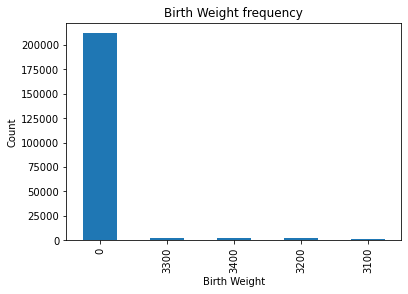

In [11]:
#Birth weight column
(df['Birth_Weight'].value_counts().head(5)).plot(kind='bar')
plt.xlabel('Birth Weight')
plt.ylabel('Count')
plt.title('Birth Weight frequency')
# appears that majority of the hospital admissions do not constitue newborns
df[df['Birth_Weight']==0].shape

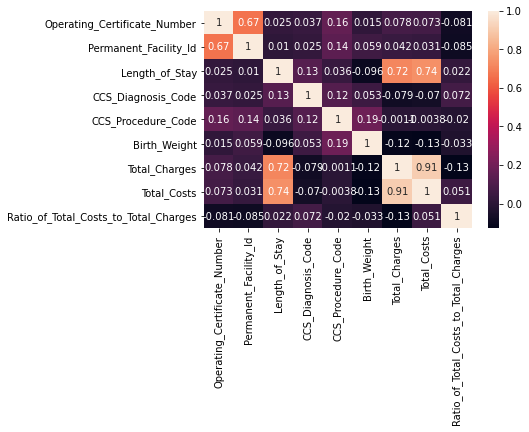

In [12]:
# create a correlation matrix, some of the columns are non ordered data...(operating_certificate_number, permenant_facility_id,diagnosis and procedure codes)
correlation_mat = df.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [13]:
#1 The correlation is strongest between total costs and total_charges is strong at .91 which makes sense,
# but this is determined at the end of stay and may not help us predict length of stay,
# so should we take this into consideration?

#2 length of stay and total_charges and total_costs is at .72 and .74 respectively,
# this does make sense as a higher length of stay will correspond to increase costs and charges,
# but again, will the total cost and charge predict length of stay?

#3 lastly operating certficate number and permenant facility id show correlation. 
#The id's are non-ordered , would this correlation then still be relevant? Which other columns to drop?:

#In the context of which variable will predict length of stay,
#I am differentiating variables that are assigned at the time of diagnosis (diagnosis or procedure) 
#versus those that are established at the time of discharge. 
#Total charges, total costs, and total cost to charge ratio are identified after length of stay is complete and thus not useful in predicting length of stay, although the converse will hold true.

In [14]:
# create a subset focusing on relevant columns of interest, drop columns that are not useful for predicting length of stay or those that provide the same information as a column that is already included.
df=df.drop(columns=(['Operating_Certificate_Number','Permanent_Facility_Id','Patient_Disposition','Payment_Typology_2','Payment_Typology_3','Birth_Weight','Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges','CCS_Diagnosis_Code','CCS_Procedure_Code']),axis=1)

In [15]:
df.columns


Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Ethnicity',
       'Length_of_Stay', 'Type_of_Admission', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator'],
      dtype='object')

Text(0.5, 1.0, 'Length of Stay Distribution')

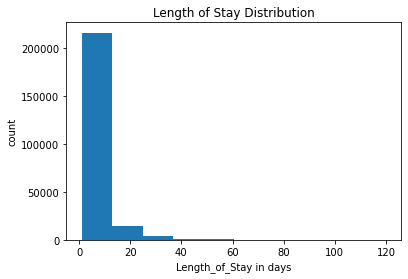

In [16]:
# Target variable is length of stay, univariate data analysis of target

plt.hist(df['Length_of_Stay'])
plt.xlabel('Length_of_Stay in days')
plt.ylabel('count')
plt.title('Length of Stay Distribution')
#plt.savefig('length.png')

In [17]:
df['Length_of_Stay'].describe()

count    236147.000000
mean          5.503043
std           8.113239
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max         120.000000
Name: Length_of_Stay, dtype: float64

In [18]:
#the mean length of stay is 5.5 days while the median is 3.00 days. 
#"There are some extreme values such as maximum length of stay which is 120"
# Lets take a look and see how many of the patients have a length of stay above the mean and below the mean

In [19]:
conditions=[(df['Length_of_Stay']<=5.5), (df['Length_of_Stay']>5.5)]
values=['below_mean','above_mean']
df['Length_groups']=np.select(conditions,values)

In [20]:
# A significant percentage (approximately 73%) of the pateint population has length of stay at or  below the mean
numbelow=(df[df['Length_groups']=='below_mean'])
percent_below_mean=((numbelow['Length_groups'].value_counts()*100)/236147)
print('percentage of patients with length of stay below mean is :{}'.format(percent_below_mean))

percentage of patients with length of stay below mean is :below_mean    73.03671
Name: Length_groups, dtype: float64


In [21]:
numabove=(df[df['Length_groups']=='above_mean'])
percent_above_mean=((numabove['Length_groups'].value_counts()*100)/236147)
mean_orlower=percent_below_mean
higherthan_mean=percent_above_mean

<ipython-input-22-7bb6bbb30c0b>:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(data, labels = labels)


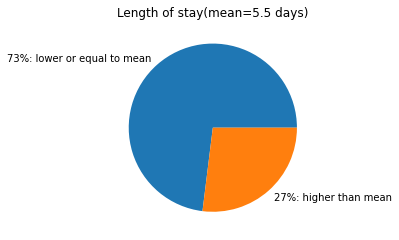

In [22]:
data=[mean_orlower,higherthan_mean]
labels=['73%: lower or equal to mean','27%: higher than mean'] 
plt.pie(data, labels = labels)
plt.title('Length of stay(mean=5.5 days)')
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig('pie.png')
plt.show()



In [23]:
# lets take a look at 13 features to see if there is any variability in the length of stay amongst these featurs. 
#define function to plot a bar graph for each feature against length of stay and describe 
def plotbar(x):
    dfh=pd.DataFrame(df.groupby(x).Length_of_Stay.mean(),columns=(x,'Length_of_Stay'))
    dfh=dfh.sort_values('Length_of_Stay')
    dfh.describe()
    dfh.head(10).plot(kind='barh') 
    plt.xlabel('length of stay in days')
    plt.ylabel(str(x))
    y=str(x)+' tail 10 table'
    plt.title(str(y))
    strx=str(x)+'head_barh.png'
    #plt.savefig(strx)
    dfh.tail(10).plot(kind='barh')
    plt.xlabel('length of stay in days')
    plt.ylabel(str(x))
    y=str(x)+' head 10 table'
    plt.title(str(y))
    strx=str(x)+'tail_barh.png'
    #plt.savefig(strx)
    
    print(dfh.describe())

In [24]:
# Explore 'U' category of gender,note how many such records are there, if less than 50, drop them.
dfunkngen=df[df['Gender']=='U']
dfunkngen.shape

(1, 15)

In [25]:
# only one record, this will be dropped
Udrop=df[df['Gender']=='U'].index
df=df.drop(Udrop,axis=0)

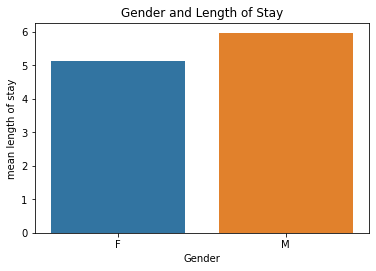

In [26]:
# Create Gender bar plot and check for statistical significance
dfgen=df.groupby('Gender')['Length_of_Stay'].mean().reset_index()
sns.barplot(x='Gender',y='Length_of_Stay',data=dfgen)
plt.xlabel('Gender')
plt.ylabel('mean length of stay')
plt.title('Gender and Length of Stay')
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig('genderbar.png')
plt.show()


In [27]:
# Males have a higher mean length of stay compared to females
# Complete an independent t-test between male and female gender groups
male=df[df['Gender']=='M']
a=male['Length_of_Stay']
female=df[df['Gender']=='F']
b=female['Length_of_Stay']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=25.217966264380546, pvalue=3.9072007331910153e-140)

       Length_of_Stay
count      258.000000
mean         5.749225
std          3.651308
min          1.000000
25%          3.451301
50%          4.885802
75%          6.817384
max         32.909091


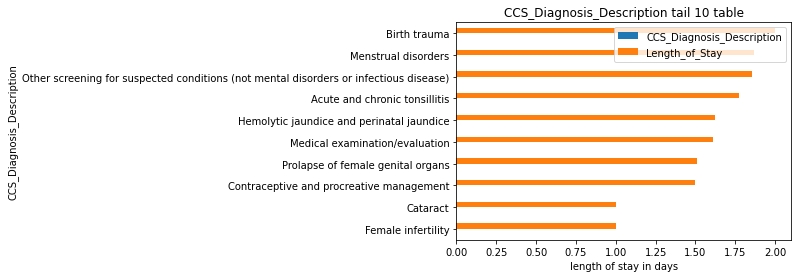

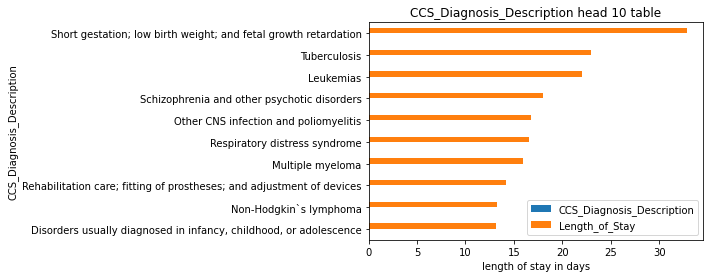

In [28]:
plotbar('CCS_Diagnosis_Description')

In [29]:
# visually we can see that there is a large amount of variablility of out target variable within the 258 CCS diagnosis description groups 

In [30]:
# There are 258 different types of diagnosis categories.Lets take a look at the top 2 most occurring
common_diag=df[df.groupby('CCS_Diagnosis_Description')['CCS_Diagnosis_Description'].transform('size') >8000]
common_diag['CCS_Diagnosis_Description'].unique().shape
common_diag['CCS_Diagnosis_Description'].unique()

array(['Septicemia (except in labor)', 'Liveborn'], dtype=object)

In [31]:
# calculate statistical significance using an independent t-test for the two most commonly occuring diagnosis
liveborn=common_diag[common_diag['CCS_Diagnosis_Description']=='Liveborn']
sep=common_diag[common_diag['CCS_Diagnosis_Description']=='Septicemia (except in labor)']
a=np.array(liveborn['Length_of_Stay'])
b=np.array(sep['Length_of_Stay'])
stats.ttest_ind(a,b)


Ttest_indResult(statistic=-55.91726158988646, pvalue=0.0)

In [32]:
# this shows that for the two most commonly occurring diagnosis, the difference in means is significant

       Length_of_Stay
count       10.000000
mean         5.468790
std          1.452146
min          4.148017
25%          4.362698
50%          4.974255
75%          6.175157
max          8.742857


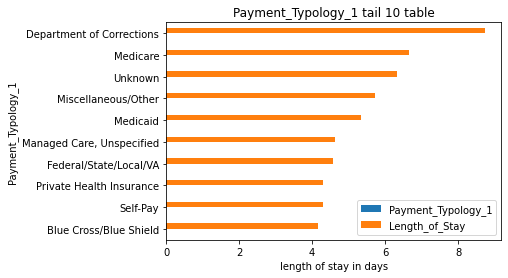

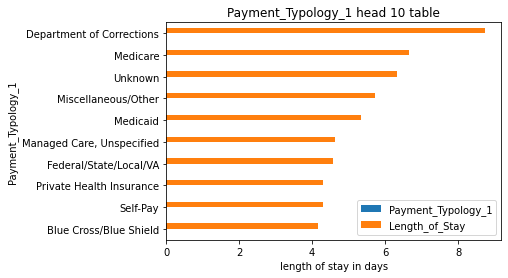

In [33]:
plotbar('Payment_Typology_1')

In [34]:
# calculate statistical signifcance of diffrence of mean length of stay among different payment type 1
a=df[df['Payment_Typology_1']=='Department of Corrections']['Length_of_Stay']
b=df[df['Payment_Typology_1']=='Medicaid']['Length_of_Stay']
c=df[df['Payment_Typology_1']=='Medicare']['Length_of_Stay']
d=df[df['Payment_Typology_1']=='Private Health Insurance']['Length_of_Stay']
e=df[df['Payment_Typology_1']=='Blue Cross/Blue Shield']['Length_of_Stay']
f=df[df['Payment_Typology_1']=='Federal/State/Local/VA']['Length_of_Stay']
g=df[df['Payment_Typology_1']=='Self-Pay']['Length_of_Stay']
h=df[df['Payment_Typology_1']=='Miscellaneous/Other']['Length_of_Stay']
i=df[df['Payment_Typology_1']=='Managed Care, Unspecified']['Length_of_Stay']
j=df[df['Payment_Typology_1']=='Unknown']['Length_of_Stay']
stats.f_oneway(a,b,c,d,e,f,g,h,i,j)

F_onewayResult(statistic=410.3651290986146, pvalue=0.0)

In [35]:
# lets create a subset of our common diagnosis dataframe where the most common 3 insurances were used: cdp
cdp=common_diag.loc[(common_diag['Payment_Typology_1']=='Medicaid')|(common_diag['Payment_Typology_1']=='Medicare')|(common_diag['Payment_Typology_1']=='Medicaid')|(common_diag['Payment_Typology_1']=='Private Health Insurance')]

Text(0.5, 1.0, 'Common Diagnosis and Insurance')

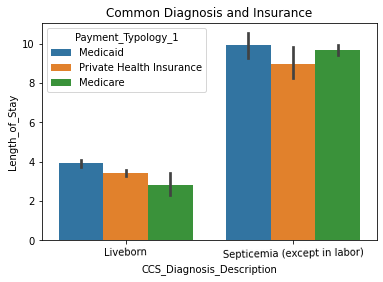

In [36]:
# Let us see the distribution of the most common diagnosis, variability with payment typology for length of stay
ax=sns.barplot(x='CCS_Diagnosis_Description',y='Length_of_Stay',hue='Payment_Typology_1',data=cdp)
plt.setp(ax.get_xticklabels(),rotation=1)
plt.title('Common Diagnosis and Insurance')
#plt.savefig('Diag_Insurance_length.png')

       Length_of_Stay
count       57.000000
mean         4.750112
std          0.830927
min          2.809524
25%          4.065789
50%          4.906942
75%          5.389008
max          6.784757


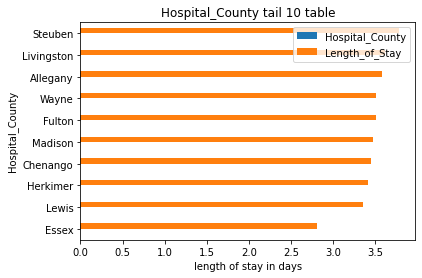

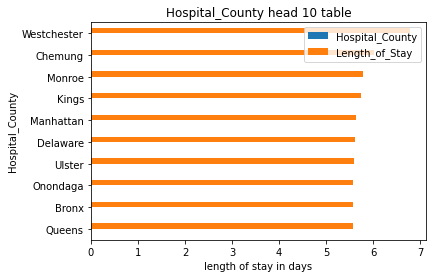

In [37]:
# look at each column of interest in the df_subset
plotbar('Hospital_County')

In [38]:
# there are 50 different counties, lets find the top two most utilsed counties and note if there is a significant difference in mean length of stay
common_county=df[df.groupby('Hospital_County')['Length_of_Stay'].transform('size') >25000]
common_county['Hospital_County'].unique().shape
common_county['Hospital_County'].unique()


array(['Kings', 'Manhattan'], dtype=object)

In [39]:
# calculate statistical significance using an independent t-test for the two most commonly used counties
Kings=common_county[common_county['Hospital_County']=='Kings']
Man=common_county[common_county['Hospital_County']=='Manhattan']
a=np.array(Kings['Length_of_Stay'])
b=np.array(Man['Length_of_Stay'])
stats.ttest_ind(a,b)


Ttest_indResult(statistic=1.5578854587248698, pvalue=0.11926512838219983)

In [40]:
# So the difference of means for the top 2 utilsed counties is not as significant. 
# But, based on the graph, the lowest mean length of stay is in Essex county at liitle more than 2.5 days and the most mean length of stay is at Westchester county more than 6.5 days

       Length_of_Stay
count        6.000000
mean         5.273322
std          0.993644
min          3.704024
25%          4.777413
50%          5.439003
75%          6.054103
max          6.241883


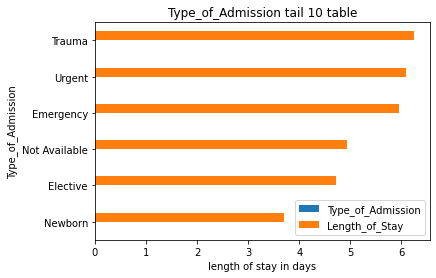

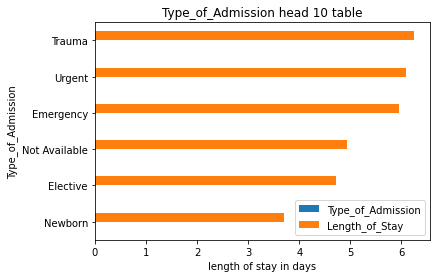

In [41]:
#It appears that people admitted for trauma have a higher mean length of stay than all the means of all the other categories

plotbar('Type_of_Admission')

In [42]:
# Run a one way ANOVA to check for statistical significance amongst different types of admissions
T=df[df['Type_of_Admission']=='Trauma']['Length_of_Stay']
U=df[df['Type_of_Admission']=='Urgent']['Length_of_Stay']
EM=df[df['Type_of_Admission']=='Emergency']['Length_of_Stay']
NA=df[df['Type_of_Admission']=='Not Available']['Length_of_Stay']
EL=df[df['Type_of_Admission']=='Elective']['Length_of_Stay']
N=df[df['Type_of_Admission']=='Newborn']['Length_of_Stay']
stats.f_oneway(T,U,EM,NA,EL,N)



F_onewayResult(statistic=424.92260864010694, pvalue=0.0)

       Length_of_Stay
count        8.000000
mean         5.380585
std          0.279910
min          5.068926
25%          5.162208
50%          5.326472
75%          5.558734
max          5.869101


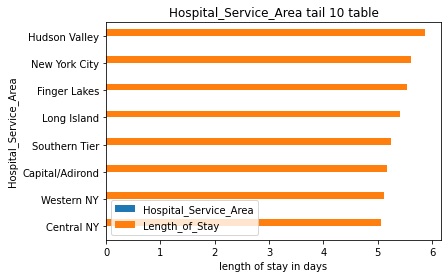

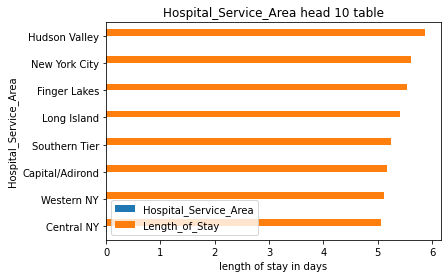

In [43]:
# it appears that the range of mean length of stay is between 5 and 6 days for Hopsital Service areas
plotbar('Hospital_Service_Area')

In [44]:
# Run a one way ANOVA to check for statistical significance amongst different types of hospital service areas
H=df[df['Hospital_Service_Area']=='Hudson Valley']['Length_of_Stay']
N=df[df['Hospital_Service_Area']=='New York City']['Length_of_Stay']
F=df[df['Hospital_Service_Area']=='Finger Lakes']['Length_of_Stay']
L=df[df['Hospital_Service_Area']=='Long Island']['Length_of_Stay']
S=df[df['Hospital_Service_Area']=='Southern Tier']['Length_of_Stay']
C=df[df['Hospital_Service_Area']=='Capital/Adirond']['Length_of_Stay']
W=df[df['Hospital_Service_Area']=='Western NY']['Length_of_Stay']
CE=df[df['Hospital_Service_Area']=='Central NY']['Length_of_Stay']
stats.f_oneway(H,N,F,L,S,C,W,CE)

F_onewayResult(statistic=26.87953448174086, pvalue=3.814360218400268e-37)

       Length_of_Stay
count      228.000000
mean         6.178137
std          5.008150
min          2.000000
25%          4.228729
50%          4.973802
75%          6.186719
max         54.916667


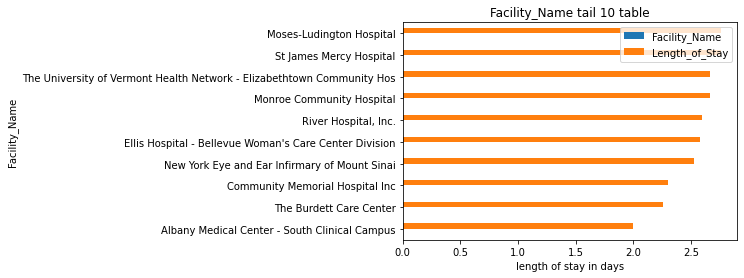

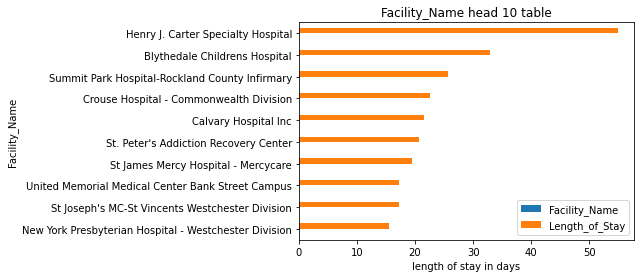

In [45]:
# There appears to be quite a large variablity in mean length of stay dpeending on the facility, 
#this is not surprisng as facilities may be be designated differently as trauma centers, rehabilitation hospitals etc
plotbar('Facility_Name')

In [46]:
# check fpr most commonly utilised facilities
common_fac=df[df.groupby('Facility_Name')['Facility_Name'].transform('size') >4500]
common_fac['Facility_Name'].unique()

array(['Mount Sinai Hospital',
       'New York Presbyterian Hospital - New York Weill Cornell Center',
       'New York Presbyterian Hospital - Columbia Presbyterian Center',
       'North Shore University Hospital'], dtype=object)

In [47]:
# check for statistical significance of means among length of stay for most commonly used facilities
a=df[df['Facility_Name']=='Mount Sinai Hospital']['Length_of_Stay']
b=df[df['Facility_Name']=='New York Presbyterian Hospital - New York Weill Cornell Center']['Length_of_Stay']
c=df[df['Facility_Name']=='New York Presbyterian Hospital - Columbia Presbyterian Center']['Length_of_Stay']
d=df[df['Facility_Name']=='North Shore University Hospital']['Length_of_Stay']
stats.f_oneway(a,b,c,d)

F_onewayResult(statistic=14.025256501959904, pvalue=3.948765908770726e-09)

       Length_of_Stay
count       51.000000
mean         5.444053
std          0.490525
min          4.688165
25%          5.122078
50%          5.347367
75%          5.724928
max          7.015134


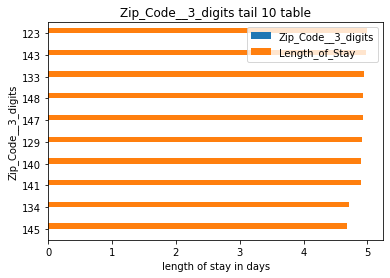

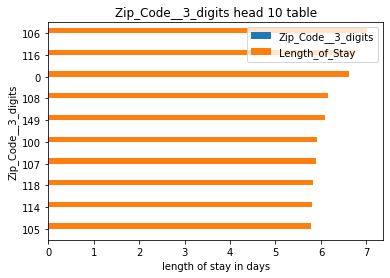

In [48]:
# it appears that there is some variability in mean length of stay by zipcode
plotbar('Zip_Code__3_digits')

In [49]:
# check for frequently utilised zip codes
common_zip=df[df.groupby('Zip_Code__3_digits')['Zip_Code__3_digits'].transform('size') > 10000]
common_zip['Zip_Code__3_digits'].unique()

array(['112', '117', '104', '100', '113'], dtype=object)

In [50]:
# check for statistical significance for most frequently utilised zip codes
a=df[df['Zip_Code__3_digits']=='112']['Length_of_Stay']
b=df[df['Zip_Code__3_digits']=='117']['Length_of_Stay']
c=df[df['Zip_Code__3_digits']=='104']['Length_of_Stay']
d=df[df['Zip_Code__3_digits']=='100']['Length_of_Stay']
e=df[df['Zip_Code__3_digits']=='113']['Length_of_Stay']
stats.f_oneway(a,b,c,d,e)

F_onewayResult(statistic=14.213260703491038, pvalue=1.3379951639115776e-11)

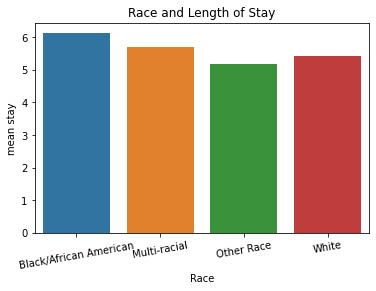

In [51]:
dfrace=df.groupby('Race')['Length_of_Stay'].mean().reset_index()
ax=sns.barplot(x='Race',y='Length_of_Stay',data=dfrace)
plt.setp(ax.get_xticklabels(),rotation=10)
plt.xlabel('Race')
plt.ylabel('mean stay')
plt.title('Race and Length of Stay')
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig('bar_race.png')
plt.show()

In [52]:
# Run a one way ANOVA to check for statistical significance
AA=df[df['Race']=='Black/African American']['Length_of_Stay']
MR=df[df['Race']=='Multi-racial']['Length_of_Stay']
WH=df[df['Race']=='White']['Length_of_Stay']
OR=df[df['Race']=='Other Race']['Length_of_Stay']
stats.f_oneway(AA,MR,WH,OR)

F_onewayResult(statistic=126.82743203121542, pvalue=4.352159594213196e-82)

       Length_of_Stay
count        4.000000
mean         5.145224
std          0.517658
min          4.471805
25%          4.872897
50%          5.265298
75%          5.537625
max          5.578497


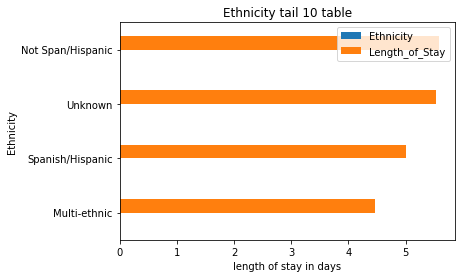

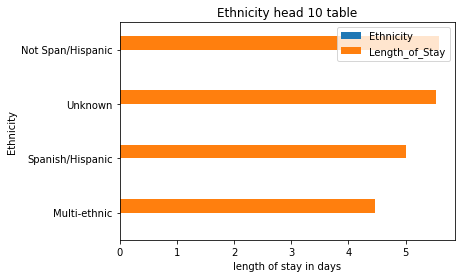

In [53]:
# in this feature the primary groups are Spanish/Hispanic and the other group categories are not as distinct, 
#this column due to lack of useful seperation of groups may be dropeed
plotbar('Ethnicity')

In [54]:
df=df.drop('Ethnicity',axis=1)

       Length_of_Stay
count      227.000000
mean         6.793957
std          4.900731
min          1.543478
25%          4.041769
50%          5.726257
75%          8.191443
max         41.072193


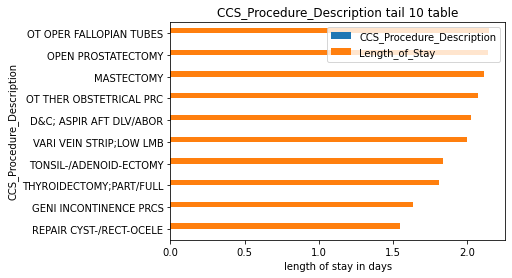

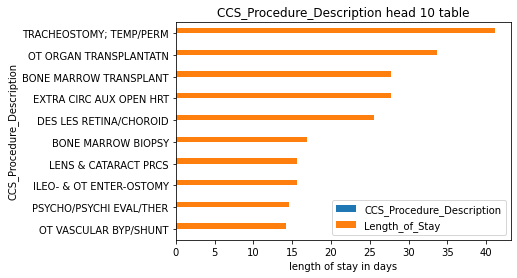

In [55]:
#there are 227 different types of CCS procedure groups with variability between the groups
plotbar('CCS_Procedure_Description')

In [56]:
common_proc=df[df.groupby('CCS_Procedure_Description')['CCS_Procedure_Description'].transform('size') > 8000]
common_proc['CCS_Procedure_Description'].unique().shape
common_proc['CCS_Procedure_Description'].unique()

array(['NO PROC', 'PROPHYLACTIC VAC/INOCUL', 'OTHER THERAPEUTIC PRCS'],
      dtype=object)

In [57]:
vac=df[df['CCS_Procedure_Description']=='PROPHYLACTIC VAC/INOCUL']
a=vac['Length_of_Stay']
ther=df[df['CCS_Procedure_Description']=='OTHER THERAPEUTIC PRCS']
b=ther['Length_of_Stay']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-30.830323156354137, pvalue=8.237245017614374e-205)

In [58]:
# lets look at the top 5 most commonly utilsed CCS procedure descriptions 
common_proc=df[df.groupby('CCS_Procedure_Description')['CCS_Procedure_Description'].transform('size') > 7200]
common_proc['CCS_Procedure_Description'].unique().shape
common_proc['CCS_Procedure_Description'].unique()

array(['NO PROC', 'OT PRCS TO ASSIST DELIV', 'CESAREAN SECTION',
       'PROPHYLACTIC VAC/INOCUL', 'OTHER THERAPEUTIC PRCS'], dtype=object)

In [59]:
#df.to_csv('NYSDOH_clean3.csv')

Text(0.5, 1.0, 'Age Groups')

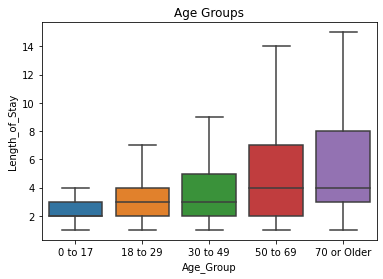

In [60]:
ax=sns.boxplot(x='Age_Group',y='Length_of_Stay',data=df,showfliers=False,order=['0 to 17','18 to 29','30 to 49','50 to 69','70 or Older'])
ax.set_title('Age Groups')
#plt.savefig('AgeGenderbox.png')

In [61]:
  # The 70 or older group seems to have a slightly higher mean length of stay compared to the other groups, 
# we will check for statistical signififcance for difference of means amongst different age groups using a one way ANOVA.

a=df[df['Age_Group']=='0 to 17']['Length_of_Stay']
b=df[df['Age_Group']=='18 to 29']['Length_of_Stay']
c=df[df['Age_Group']=='30 to 49']['Length_of_Stay']
d=df[df['Age_Group']=='50 to 69']['Length_of_Stay']
e=df[df['Age_Group']=='70 or Older']['Length_of_Stay']
stats.f_oneway(a,b,c,d,e)

F_onewayResult(statistic=769.3875943548376, pvalue=0.0)

       Length_of_Stay
count        2.000000
mean         5.444046
std          0.530561
min          5.068883
25%          5.256465
50%          5.444046
75%          5.631628
max          5.819209


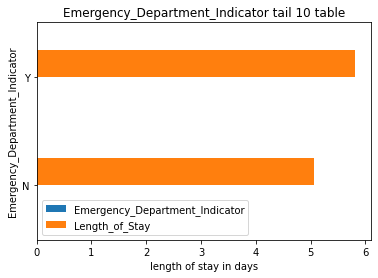

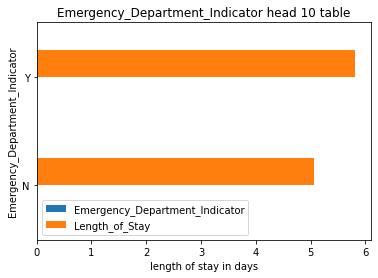

In [62]:
plotbar('Emergency_Department_Indicator')

In [63]:
a=df[df['Emergency_Department_Indicator']=='Y']['Length_of_Stay']
b=df[df['Emergency_Department_Indicator']=='N']['Length_of_Stay']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=22.214070269392238, pvalue=3.2519747740194475e-109)

In [65]:
#Convert categorical data to numeric using get_dummies to prepare for further processing
X=df.drop(['Length_of_Stay','Length_groups'],axis=1)

In [66]:
X=pd.get_dummies(data=X,drop_first=True)

In [67]:
X.shape

(236146, 846)

In [68]:
df.to_csv('X.csv')

In [69]:
y=df['Length_of_Stay']

In [70]:
df.to_csv('y.csv')

In [71]:
#df.to_csv('NYSDOH_df1.csv')